In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
from pickle import load
from math import ceil
from numpy.random import choice
from keras import Model
from keras.applications import ResNet152V2
from keras.layers import Input, Dense, LSTM, Embedding, Add, Dropout
from keras import layers
from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy
from keras.callbacks import EarlyStopping, TensorBoard
from keras.applications import InceptionResNetV2

from functions.text_processing import create_vocab_mappings
from functions.image_processing import display_image
from functions.training import data_generator
from functions.model_evaluation import generate_and_evaluate_caption
from keras.utils import plot_model

from functions.model_evaluation import generate_captions, evaluate_captions


# from keras.mixed_precision import set_global_policy
# set_global_policy("mixed_float16")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\james\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
SEQ_LENGTH = 15
EMBED_DIM = 300
FF_DIM = 512
HIDDEN_DIM = 512
EPOCHS = 100
DROPOUT = 0.4
BATCH_SIZE = 256
EVAL_BATCH_SIZE = 1024
DIR = 'preprocessed_data/coco/'

In [3]:
with open('preprocessed_data/vocab.pkl', 'rb') as file:
    vocab = load(file)
    
VOCAB_SIZE = len(vocab)
    
with open('preprocessed_data/embedding_matrix.pkl', 'rb') as file:
    embedding_matrix = load(file)
    
EMBED_DIM = embedding_matrix.shape[1]

word_to_idx, idx_to_word = create_vocab_mappings(vocab)

In [4]:
DIR = 'preprocessed_data/coco/'

with open(DIR + 'train_caption_map.pkl', 'rb') as file:
    train_caption_map = load(file)
    
with open(DIR + 'train_avg_feature_map.pkl', 'rb') as file:
    train_feature_map = load(file)
    
train_images = list(train_caption_map.keys())
STEPS = ceil(len(train_images) * 5 / BATCH_SIZE)
    
train_data = data_generator (train_images, train_caption_map, train_feature_map, BATCH_SIZE)

with open(DIR + 'val_caption_map.pkl', 'rb') as file:
    val_caption_map = load(file)
    
with open(DIR + 'val_avg_feature_map.pkl', 'rb') as file:
    val_feature_map = load(file)
    
val_images = list(val_caption_map.keys())
VAL_STEPS = ceil(len(val_images) * 5 / BATCH_SIZE)
val_data = data_generator(val_images, val_caption_map, val_feature_map, BATCH_SIZE)

In [5]:
'''
The layers: 
- TransformerEncoderBlock
- PositionalEmbedding
- TransformerDecoderBlock 

Are from the Keras image captioning example
- Author: A_K_Nain
- Source: https://keras.io/examples/vision/image_captioning/#building-the-model
'''

class TransformerEncoderBlock(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.0
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.dense_1 = layers.Dense(embed_dim, activation="relu")

    def call(self, inputs, training, mask=None):
        inputs = self.layernorm_1(inputs)
        inputs = self.dense_1(inputs)
        
        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=None,
            training=training,
        )
        out_1 = self.layernorm_2(inputs + attention_output_1)
        return out_1


class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, embedding_matrix, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = Embedding(
            input_dim=vocab_size, 
            output_dim=embed_dim,
            input_length=sequence_length,
            trainable=False,
            weights=[embedding_matrix]
        )
        self.position_embeddings = Embedding(
            input_dim=sequence_length,
            output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.embed_scale = tf.math.sqrt(tf.cast(embed_dim, tf.float32))

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_tokens = embedded_tokens * self.embed_scale
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)


class TransformerDecoderBlock(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, embedding_matrix, ff_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.ffn_layer_1 = layers.Dense(ff_dim, activation="relu")
        self.ffn_layer_2 = layers.Dense(embed_dim)

        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()

        self.embedding = PositionalEmbedding(
            embed_dim=embed_dim,
            sequence_length=sequence_length,
            vocab_size=vocab_size,
            embedding_matrix=embedding_matrix
        )
        self.out = layers.Dense(vocab_size, activation="softmax")

        self.dropout_1 = layers.Dropout(0.3)
        self.dropout_2 = layers.Dropout(0.5)
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, training, mask=None):
        inputs = self.embedding(inputs)
        causal_mask = self.get_causal_attention_mask(inputs)

        if mask is not None:
            padding_mask = tf.cast(mask[:, :, tf.newaxis], dtype=tf.int32)
            combined_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.int32)
            combined_mask = tf.minimum(combined_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=combined_mask,
            training=training,
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
            training=training,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        ffn_out = self.ffn_layer_1(out_2)
        ffn_out = self.dropout_1(ffn_out, training=training)
        ffn_out = self.ffn_layer_2(ffn_out)

        ffn_out = self.layernorm_3(ffn_out + out_2, training=training)
        ffn_out = self.dropout_2(ffn_out, training=training)
        preds = self.out(ffn_out)
        return preds

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [
                tf.expand_dims(batch_size, -1),
                tf.constant([1, 1], dtype=tf.int32),
            ],
            axis=0,
        )
        return tf.tile(mask, mult)

class ImageCaptioningModel(Model):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.encoder = TransformerEncoderBlock(embed_dim=EMBED_DIM, dense_dim=FF_DIM, num_heads=2)
        self.decoder = TransformerDecoderBlock(sequence_length=SEQ_LENGTH, vocab_size=VOCAB_SIZE, embed_dim=EMBED_DIM, embedding_matrix=embedding_matrix, ff_dim=FF_DIM, num_heads=8)
        
    def call(self, inputs):
        image_features, input_captions = inputs
        reshaped_image_features = layers.Reshape((1, -1))(image_features)
        encoder_out = self.encoder(reshaped_image_features, training=True)
        mask = tf.math.not_equal(input_captions, 0)
        output = self.decoder(input_captions, encoder_out, training=True, mask=mask) 
        return output

In [7]:
model = ImageCaptioningModel()

model.compile(loss= SparseCategoricalCrossentropy(), optimizer= Adam(0.001), metrics=['accuracy'] )

callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
]

training = model.fit(
    train_data,
    epochs=100,
    steps_per_epoch=STEPS,
    validation_data=val_data,
    validation_steps=VAL_STEPS,
    callbacks= callbacks,
    verbose=1)

Epoch 1/100
809/809 [==============================] - 61s 73ms/step - loss: 1.9446 - accuracy: 0.4114 - val_loss: 1.7473 - val_accuracy: 0.4429
Epoch 2/100
809/809 [==============================] - 58s 72ms/step - loss: 1.6992 - accuracy: 0.4512 - val_loss: 1.6909 - val_accuracy: 0.4527
Epoch 3/100
809/809 [==============================] - 58s 72ms/step - loss: 1.6476 - accuracy: 0.4610 - val_loss: 1.6541 - val_accuracy: 0.4623
Epoch 4/100
809/809 [==============================] - 58s 72ms/step - loss: 1.6170 - accuracy: 0.4674 - val_loss: 1.6345 - val_accuracy: 0.4664
Epoch 5/100
809/809 [==============================] - 58s 72ms/step - loss: 1.5962 - accuracy: 0.4713 - val_loss: 1.6199 - val_accuracy: 0.4700
Epoch 6/100
809/809 [==============================] - 58s 72ms/step - loss: 1.5815 - accuracy: 0.4741 - val_loss: 1.6129 - val_accuracy: 0.4710
Epoch 7/100
809/809 [==============================] - 58s 72ms/step - loss: 1.5720 - accuracy: 0.4759 - val_loss: 1.6100 - val_ac

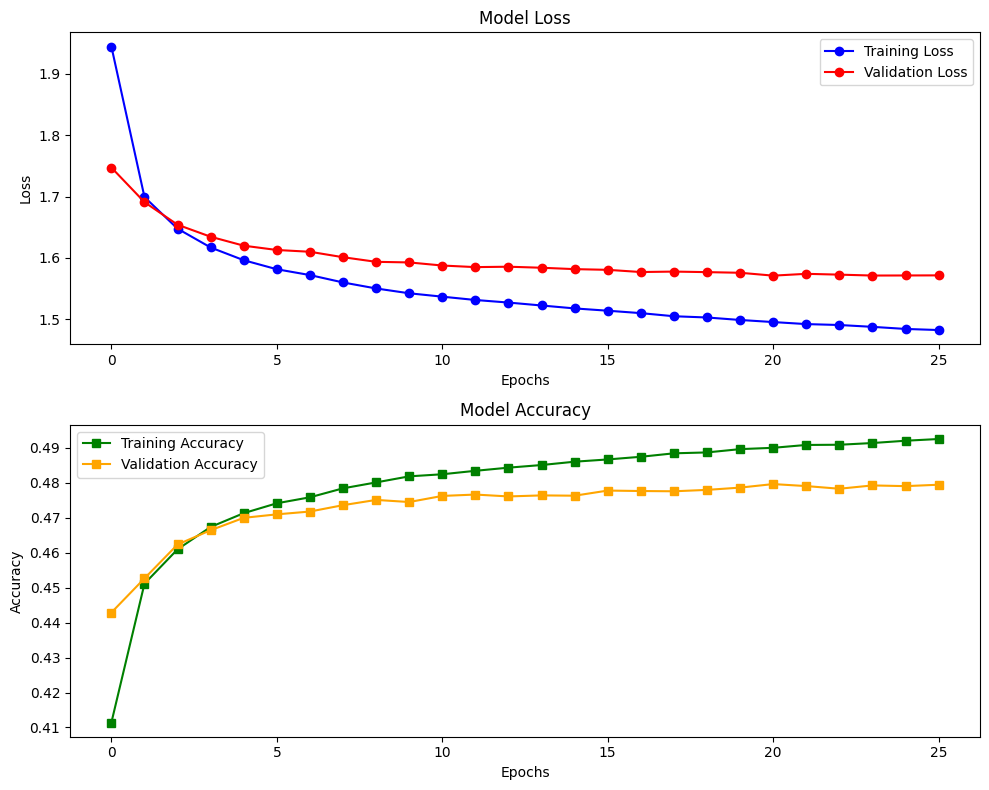

In [8]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

# Plotting Loss
axes[0].plot(training.history['loss'], marker='o', color='b', label='Training Loss')
axes[0].plot(training.history['val_loss'], marker='o', color='r', label='Validation Loss')
axes[0].set_title('Model Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()

# Plotting Accuracy
axes[1].plot(training.history['accuracy'], marker='s', color='g', label='Training Accuracy')
axes[1].plot(training.history['val_accuracy'], marker='s', color='orange', label='Validation Accuracy')
axes[1].set_title('Model Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.tight_layout()
plt.show()

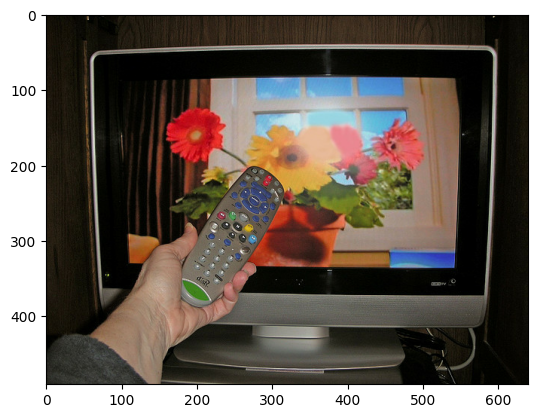

['a', 'person', 'holding', 'a', 'remote', 'control', 'in', 'front', 'of', 'a', 'tv'] 

['a', 'person', 'holding', 'a', 'remote', 'in', 'front', 'of', 'a', 'tv'] 

['a', 'remote', 'that', 'is', 'being', 'pointed', 'at', 'a', 'television']
['a', 'tv', 'remote', 'control', 'being', 'held', 'in', 'front', 'of', 'flowers', 'on', 'a', 'screen']
['a', 'person', 'holds', 'a', 'remote', 'and', 'points', 'it', 'toward', 'a', 'tv', 'with', 'a', 'large', 'flower', 'pot', 'wit', 'colorful', 'flowers', 'in']
['there', 'is', 'a', 'television', 'that', 'is', '[UNK]', 'a', 'vase', 'with', 'flowers']
['a', 'picture', 'of', 'red', 'and', 'yellow', 'flowers', 'on', 'a', 'tv', 'screen', 'with', 'a', 'hand', 'holding', 'a', 'remote']
0.5487060546875001 0.4970472440944882


In [18]:
test_image = choice(val_images)
test_features = val_feature_map[test_image]
target_captions = val_caption_map[test_image]

display_image('datasets/coco/val2014/', test_image)

greedy, beam, true_captions = generate_and_evaluate_caption(model, test_features, target_captions, idx_to_word, SEQ_LENGTH)
print(greedy[0], '\n')
print(beam[0], '\n')

for caption in true_captions: 
    print(caption)
    
print(greedy[2], beam[2])

In [10]:
predicted_captions, true_captions = generate_captions(model, val_images[:1024], val_feature_map, val_caption_map, idx_to_word, batch_size=32)
validation_score = evaluate_captions(predicted_captions, true_captions)
print(validation_score)

([0.6564064556023911, 0.4586642511257517, 0.3053014903103866, 0.20912382245341962], 0.40416116692425974)


- ([0.6566525747696405,
  0.46475125022830116,
  0.311301620339562,
  0.21286200107485656],
 0.41116280406869266) first iteration 5 epochs 
 - ([0.6641633469587254,
  0.4708016193944267,
  0.31741534441381347,
  0.21806740313687273],
 0.4172896946730811) 13 epochs
 - ([0.6670269463236829,
  0.47334294126193033,
  0.32004501765654514,
  0.2204260870604908],
 0.41942539024956743) 10 epochs with 16 attention heads

In [11]:
model.save('saved_models/transformer_decoder_v1')

INFO:tensorflow:Assets written to: saved_models/transformer_decoder_v1\assets


INFO:tensorflow:Assets written to: saved_models/transformer_decoder_v1\assets
c:\Projects\coursework\.venv\lib\site-packages\keras\saving\saved_model\layer_serialization.py:134: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)
